# Specific Heat Capacity from pycalphad

In this notebook, the interaction between PyRolL and pycalphad is demonstrated. 
In this example, the calphad method is used to calculate the specific heat capacity of the low-carbon steel C15 (1.0401) using free `tdb` databases provided by [MatCalc Engineering GmbH](https://www.matcalc.at/index.php/databases/open-databases). The measured chemical composition (wt%) of a example can be seen in the following table: 

| Steel grade  | C    | Si   | Mn   | Cr   | Ni   | Cu   | P     | S      | Fe    |
|--------------|------|------|------|------|------|------|-------|--------|-------|
| C15 (1.0401) | 0.16 | 0.16 | 0.69 | 0.12 | 0.09 | 0.17 | 0.002 | 0.0065 | 98.43 |

Further, thermodynamical database files (`tdb`) for other alloying systems can be found [here](https://avdwgroup.engin.brown.edu/). The specific-heat-capacity is mostly important when considering cooling processes which often follow a hot rolling process. As always, we first import the necessary python modules.

In [5]:
import numpy as np
import pyroll.core as pr
import matplotlib.pyplot as plt
import pycalphad.variables as v
import scipy.interpolate as interpolate

from pycalphad import Database
from pycalphad import equilibrium
from pyroll.freiberg_flow_stress import FreibergFlowStressCoefficients

In [6]:
database = Database('mc_fe_v2.059.pycalphad.tdb')

/home/christoph/.local/share/virtualenvs/pyroll-examples-YS1GospC/lib/python3.10/site-packages/pycalphad/io/tdb.py:929: UserWarning: The type definition character `%` was defined in the following phases: ['LIQUID', 'FCC_A1', 'BCC_A2', 'H_BCC', 'BCC_DISL', 'HCP_A3', 'ALPHA_MN', 'BETA_MN', 'BETA_RHOMBO_B', 'DIAMOND_A4', 'GRAPHITE', 'BCC_B2', 'CHI_A12', 'CO3MO', 'CO3V', 'COV3', 'CR3MN5', 'G_PHASE', 'LAVES_PHASE', 'MNNI', 'MNNI2', 'MNNI_T3', 'MU_PHASE', 'MU_PHASE_I', 'ETA', 'NITI2', 'PI_PHASE', 'R_PHASE', 'SIGMA', 'FE17Y2', 'NI5Y', 'PDFE_L12', 'PDMN_AF', 'PDMN_P', 'PDMN_B2', 'PD2MN', 'PD3MN', 'PD5MN3', 'PD6FE5MN2', 'CEMENTITE', 'CR2VC2', 'K_CARB', 'KSI_CARBIDE', 'M3C2', 'M6C', 'M7C3', 'M12C', 'M23C6', 'MOC_ETA', 'V3C2', 'WC', 'EPS_CARB', 'ETA_CARB', 'FE24C10', 'KSI_FE5C2', 'ALN', 'ALN_EQU', 'BN_HP4', 'CR3NI2SIN', 'FE4N', 'MN6N4', 'MN6N5', 'MNSIN2', 'SI3N4', 'ZET', 'CRB', 'CR2B', 'CR5B3', 'FEB', 'FENBB', 'FE3NB3B4', 'M2B', 'MNB2', 'MNB4', 'O_MN2B', 'MN3B4', 'MOB', 'MOB2', 'MO2M1B2', 'NBB', 

In [33]:
# Composition of C15 (1.0401) steel in weight fractions (in percent)
composition = {
    'C': 0.16,
    'Si': 0.16,
    'Mn': 0.69,
    'Cr': 0.12,
    'Ni': 0.09,
    'Cu': 0.17,
    'P': 0.002,
    'S': 0.0065,
    'Fe': 98.43
}

# Molar masses of elements in g/mol
atomic_mass = {
    'C': 12.011,
    'Si': 28.085,
    'Mn': 54.938,
    'Cr': 51.996,
    'Ni': 58.693,
    'Cu': 63.546,
    'P': 30.974,
    'S': 32.06,
    'Fe': 55.845
}

# Convert weight fractions from percent to decimal
composition_decimal = {element: value / 100 for element, value in composition.items()}

# Calculate moles of each element
moles = {element: composition_decimal[element] / atomic_mass[element] for element in composition_decimal}

# Calculate the molar mass of the steel
steel_molar_mass = sum(moles[element] * atomic_mass[element] for element in moles)

print(f"The molar mass of the steel is {steel_molar_mass:.2f} g/mol.")

The molar mass of the steel is 1.00 g/mol.


## Conversion of weight-fractions to molar-fractions
The industrial standard, how to provide the chemical composition of an alloy is to use weight-fractions. In the scientific realm, however, molar-fractions are more common. Therefore, we need a function which converts weight-fractions to molar fractions. This can be handled by the `get_mole_fractions` function of `pycalphad`.

In [25]:
molar_masses = {
        'H': 1.008, 'He': 4.0026, 'Li': 6.94, 'Be': 9.0122, 'B': 10.81,
        'C': 12.011, 'N': 14.007, 'O': 15.999, 'F': 18.998, 'Ne': 20.180,
        'Na': 22.990, 'Mg': 24.305, 'Al': 26.982, 'Si': 28.085, 'P': 30.974,
        'S': 32.06, 'Cl': 35.45, 'Ar': 39.948, 'K': 39.098, 'Ca': 40.078,
        'Sc': 44.956, 'Ti': 47.867, 'V': 50.942, 'Cr': 51.996, 'Mn': 54.938,
        'Fe': 55.845, 'Co': 58.933, 'Ni': 58.693, 'Cu': 63.546, 'Zn': 65.38,
        'Ga': 69.723, 'Ge': 72.63, 'As': 74.922, 'Se': 78.971, 'Br': 79.904,
        'Kr': 83.798, 'Rb': 85.468, 'Sr': 87.62, 'Y': 88.906, 'Zr': 91.224,
        'Nb': 92.906, 'Mo': 95.95, 'Tc': 98.0, 'Ru': 101.07, 'Rh': 102.91,
        'Pd': 106.42, 'Ag': 107.87, 'Cd': 112.41, 'In': 114.82, 'Sn': 118.71,
        'Sb': 121.76, 'Te': 127.6, 'I': 126.9, 'Xe': 131.29, 'Cs': 132.91,
        'Ba': 137.33, 'La': 138.91, 'Ce': 140.12, 'Pr': 140.91, 'Nd': 144.24,
        'Pm': 145.0, 'Sm': 150.36, 'Eu': 151.96, 'Gd': 157.25, 'Tb': 158.93,
        'Dy': 162.5, 'Ho': 164.93, 'Er': 167.26, 'Tm': 168.93, 'Yb': 173.05,
        'Lu': 174.97, 'Hf': 178.49, 'Ta': 180.95, 'W': 183.84, 'Re': 186.21,
        'Os': 190.23, 'Ir': 192.22, 'Pt': 195.08, 'Au': 196.97, 'Hg': 200.59,
        'Tl': 204.38, 'Pb': 207.2, 'Bi': 208.98, 'Po': 209.0, 'At': 210.0,
        'Rn': 222.0, 'Fr': 223.0, 'Ra': 226.0, 'Ac': 227.0, 'Th': 232.04,
        'Pa': 231.04, 'U': 238.03, 'Np': 237.0, 'Pu': 244.0, 'Am': 243.0,
        'Cm': 247.0, 'Bk': 247.0, 'Cf': 251.0, 'Es': 252.0, 'Fm': 257.0,
        'Md': 258.0, 'No': 259.0, 'Lr': 266.0
    }

## Definition of incoming profile
Now let's define a profile and use it to calculate the molar fractions as well as the molar mass.

In [17]:
profile = pr.Profile.round(
    diameter=50e-3,
    temperature=1200 + 273.15,
    material=["steel", "C15"],
    density=7.5e3,
    strain=0,
    chemical_composition={
        "C": 0.16 / 100,
        "SI": 0.16 / 100,
        "MN": 0.69 / 100,
        "CR": 0.12 / 100,
        "NI": 0.09 / 100,
        "CU": 0.17 / 100,
        "P": 0.002 / 100,
        "S": 0.0065/ 100,
        "FE": 98.43 / 100
    },
    freiberg_flow_stress_coefficients=FreibergFlowStressCoefficients(
        a=2098.29 * 1e6,
        m1=-0.00272,
        m2=0.22312,
        m4=0.00003,
        m5=0.00028,
        m7=-0.58508,
        m8=0.000137,
        baseStrain=0.1,
        baseStrainRate=0.1
    )
)

In [28]:
mass_fractions = {
    v.W('C'): profile.chemical_composition['C'],
    v.W('CU'): profile.chemical_composition['CU'],
    v.W('SI'): profile.chemical_composition['SI'],
    v.W('MN'): profile.chemical_composition['MN'],
    v.W('CR'): profile.chemical_composition['CR'],
    v.W('NI'): profile.chemical_composition['NI'],
    v.W('P'): profile.chemical_composition['P'],
    v.W('S'): profile.chemical_composition['S'],
}

mole_fractions = v.get_mole_fractions(mass_fractions=mass_fractions, dependent_species=v.Species('FE'), pure_element_mass_dict=database)
alloy_molar_mass = sum(mole_fractions.get(v.MoleFraction(element), 0.0) * molar_mass for element, molar_mass in molar_masses.items())
alloy_molar_mass

0.7752536867928914

## Stepped Equilibrium 
Now we have to calculate a stepped equilibrium using the `pycalphad` package. This equilibrium gives us information about the phase compositions of the alloy at various temperatures between a start and a stop temperature. Further information we have to provide to run the calculations is the atmospheric pressure as well as the number of moles we want to consider. Also, we need information about the expected phases. This information can be gained from literature or a phase diagram. In this case we expect the liquid phase (LIQUID), cementite (CEMENTITE), austenite (FCC_A1) as well as ferrite (BCC_A2) regarding the temperature. At last the composition (chemical elements) of the alloy.

In [29]:
start_temperature_kelvin = 298.15 + 273.15
end_temperature_kelvin = 1200 + 273.15
number_of_moles = 1
atmospheric_pressure = 101325

conditions = {
    v.X('C'): mole_fractions[v.MoleFraction(v.Species('C'))],
    v.X('CU'): mole_fractions[v.MoleFraction(v.Species('CU'))],
    v.X('SI'): mole_fractions[v.MoleFraction(v.Species('SI'))],
    v.X('MN'): mole_fractions[v.MoleFraction(v.Species('MN'))],
    v.X('CR'): mole_fractions[v.MoleFraction(v.Species('CR'))],
    v.X('NI'): mole_fractions[v.MoleFraction(v.Species('NI'))],
    v.X('P'): mole_fractions[v.MoleFraction(v.Species('P'))],
    v.X('S'): mole_fractions[v.MoleFraction(v.Species('S'))],
    v.N: number_of_moles,
    v.P: atmospheric_pressure,
    v.T: (start_temperature_kelvin, end_temperature_kelvin, 10)  # temperature (start, stop, step)
}
phases = ['LIQUID', 'FCC_A1', 'BCC_A2', 'CEMENTITE']
composition = ['FE', 'C', 'CU', 'SI', 'MN', 'CR', 'NI', 'P', 'S', 'VA']
eq = equilibrium(database, composition, phases, conditions, output=['heat_capacity'])
specific_heat_capacity = np.squeeze(eq['heat_capacity'].values) / alloy_molar_mass
temperature = eq['T'].values
specific_heat_capacity

array([40.00848221, 40.35794648, 40.71418395, 41.07751427, 41.44827067,
       41.82680182, 42.21347378, 42.60867201, 43.01280359, 43.42629972,
       43.84961839, 44.28324758, 44.72770871, 45.19261146, 45.65866264,
       46.13755937, 46.62998964, 47.13667728, 47.65843244, 48.19614024,
       48.75076984, 49.32338438, 49.91515219, 50.52735918, 51.16142285,
       51.81890773, 52.50154282, 53.21016862, 53.94654301, 54.71396219,
       55.51495489, 56.35232486, 57.22918213, 58.14897842, 59.11554665,
       60.13314501, 61.20497125, 62.33695486, 63.53523955, 64.80621158,
       66.156964  , 66.2939219 , 62.96408242, 63.44692494, 63.79483668,
       63.96502788, 63.9098479 , 55.5374538 , 53.34612686, 51.27441397,
       49.25767135, 47.23414195, 45.14463729, 42.94096042, 42.88668936,
       42.99659266, 43.10650248, 43.21642177, 43.32635331, 43.43629978,
       43.54626374, 43.65624767, 43.76625391, 43.87628474, 43.98634232,
       44.09642874, 44.20654601, 44.31669604, 44.4268807 , 44.53

## Extracting the specific-heat-capacity 
Now let's inspect the result. And check if the results are correct, comparing them to values taken from "Numerical data 
More methods about how to check if the results are valid, can be taken from the pycalphad documentation which can be found [here](https://pycalphad.org/docs/latest/examples/EquilibriumWithOrdering.html).

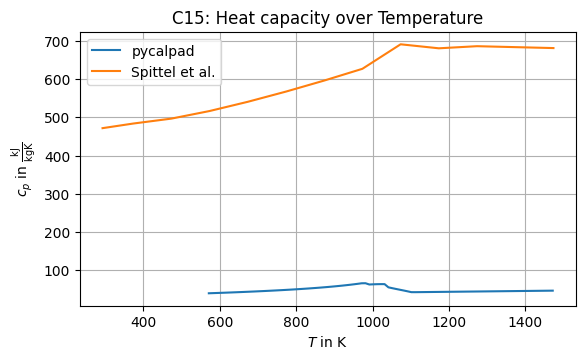

In [30]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

specific_heat_capacity_spittel = np.array(
    [472.11, 484.14, 497.07, 516.92, 541.07, 567.8, 596.65, 627.42, 691.57, 681.08, 686.60, 684.14, 681.68])
temperatures_spittel = np.array([20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) + 273.15

ax.set_title('C15: Heat capacity over Temperature')
ax.set_xlabel(r"$T$ in $\mathrm{K}$")
ax.set_ylabel(r"$c_{p}$ in $\mathrm{\frac{kJ}{kg K}}$")
ax.grid(True)
ax.set_aspect("equal")
ax.plot(temperature, specific_heat_capacity, label='pycalpad')
ax.plot(temperatures_spittel, specific_heat_capacity_spittel, label='Spittel et al.')
ax.legend()
plt.show()

J7## Usage of the data in PyRolL
Now let's interpolate the gained values and use them for a simulation in PyRolL.

In [13]:
specific_heat_capacity_function = interpolate.interp1d(temperature, specific_heat_capacity)


@pr.DeformationUnit.Profile.specific_heat_capacity
def heat_capacity_interpolated(self: pr.DeformationUnit.Profile):
    return specific_heat_capacity_function(self.temperature)


sequence = pr.PassSequence([
    pr.RollPass(
        label="K 02/001 - 1",
        roll=pr.Roll(
            groove=pr.SwedishOvalGroove(
                r1=6e-3,
                r2=26e-3,
                ground_width=38e-3,
                usable_width=60e-3,
                depth=7.25e-3
            ),
            nominal_radius=321e-3 / 2,
            rotational_frequency=0.99,

        ),
        gap=13.5e-3,
        coulomb_friction_coefficient=0.4,
        back_tension=0,
        front_tension=0
    ),
    pr.Transport(
        label="I->II",
        duration=6,
    )
])

sequence.solve(profile)

Profile(
    chemical_composition={'C': 0.16,
     'Si': 0.16,
     'Mn': 0.02,
     'P': 0.002,
     'S': 0.0065,
     'Fe': 98.43},
    classifiers={'generic_elongation', 'oval', 'swedish_oval'},
    cross_section=Polygon(
        area=0.0014976631456151905,
        height=0.027999999999999997,
        perimeter=0.1545024092875257,
        width=0.06,
        ),
    density=7500.0,
    freiberg_flow_stress_coefficients=FreibergFlowStressCoefficients(a=2098290000.0, m1=-0.00272, m2=0.22312, m3=0, m4=3e-05, m5=0.00028, m6=0, m7=-0.58508, m8=0.000137, m9=0, baseStrain=0.1, baseStrainRate=0.1),
    length=0.0,
    material=['steel', 'C15'],
    strain=0,
    t=6.0571064266249754,
    temperature=1473.15,
    )